# EDA of AIS Data & Building ML Model for Vessel's Anomaly Behaviour Detection

## Overview:
Vessel traffic data, or Automatic Identification System (AIS) data, are collected by the U.S. Coast Guard through an onboard navigation safety device that transmits and monitors the location and characteristics of large vessels in U.S. and international waters in real time. In the U.S., the Coast Guard and commercial vendors collect AIS data, which can also be used for a variety of coastal planning purposes.

The Bureau of Ocean Energy Management (BOEM) and the National Oceanic and Atmospheric Administration (NOAA) have worked jointly to repurpose and make available some of the most important records from the U.S. Coast Guard’s national network of AIS receivers. Information such as location, time, ship type, speed, length, beam, and draft have been extracted from the raw data and prepared for analyses.

So in this project, we'll perform some basic exploratory data analysis on AIS data, after that we'll make the <b>ML(SVR)</b> model to identify vessel anomaly behavior detection.


## Data Source

 https://marinecadastre.gov/ais/
 
 We'll performe analysis on <b>AIS_2017_01_Zone10</b> dataset.

<a id='toc'></a>
## Table of Content:

[1.Exploratory Data Analysis of csv file (January, UTM Zone 10, 2017)](#l1)<br>
>[1.1. Visualizations (Graphing latitude, longitude points onto a map)](#l1.1)<br>
[1.2. What is the average track length?](#l1.2)<br>
[1.3. Does SOG and COG vary depending on vessel type?](#l1.3)<br>
[1.4. How does vessel size (length and width) modify SOG or COG)?](#l1.4)<br>
[1.5. What is the average speed of the ships?](#l1.5)<br>
[1.6. How to modify the BaseDateTime column for analysis?](#l1.6)<br>

[2. Data Cleaning](#l2)<br>
>[2.1. Data contains missing values (how to use linear interpolation to solve it?)](#l2.1)

[3. Create a machine learning model that detects anomalies in vessel tracks](#l3)<br>
>[3.1. How to calculate the track of a vessel (one MMSI represents one single vessel)](#l3.1)<br>
[3.2. Build SVR Model to identify vessel's anomaly behaviour detection](#l3.2)

[Conclusion](#conclusion)

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Data Understanding

In [2]:
# read_data file
data = pd.read_csv('AIS_2017_01_Zone01.csv')

In [3]:
data.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,366940480,2017-01-04T11:39:36,52.48730,-174.02316,10.0,-140.7,267.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
1,366940480,2017-01-04T11:40:45,52.48718,-174.02835,10.0,-141.6,266.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
2,366940480,2017-01-04T11:42:26,52.48705,-174.03608,10.0,-142.3,267.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
3,366940480,2017-01-04T13:51:07,52.41575,-174.60041,9.1,-154.0,251.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
4,366940480,2017-01-04T13:55:17,52.41311,-174.61718,9.1,-157.3,251.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0


In [4]:
data.tail()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
10219,352844000,2017-01-31T22:51:31,51.89778,-176.59334,0.6,30.2,121.0,JACHA,IMO8512920,3EFC4,1004.0,at anchor,92.21,16.21,6.6,70.0
10220,352844000,2017-01-31T23:06:31,51.89795,-176.59333,0.5,-112.3,145.0,JACHA,IMO8512920,3EFC4,1004.0,at anchor,92.21,16.21,6.6,70.0
10221,352844000,2017-01-31T23:12:31,51.89772,-176.59347,0.3,1.4,119.0,JACHA,IMO8512920,3EFC4,1004.0,at anchor,92.21,16.21,6.6,70.0
10222,352844000,2017-01-31T23:30:32,51.89760,-176.59321,1.1,-104.6,156.0,JACHA,IMO8512920,3EFC4,1004.0,at anchor,92.21,16.21,6.6,70.0
10223,352844000,2017-01-31T23:33:32,51.89748,-176.59305,0.5,99.1,118.0,JACHA,IMO8512920,3EFC4,1004.0,at anchor,92.21,16.21,6.6,70.0


In [5]:
data.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo'],
      dtype='object')

In [6]:
data.describe()

,MMSI,LAT,LON,SOG,COG,Heading,VesselType,Length,Width,Draft,Cargo
count,1.022400e+04,10224.000000,10224.000000,10224.000000,10224.000000,10224.000000,10157.000000,10157.000000,9957.000000,9178.000000,6720.000000
mean,3.601466e+08,52.864806,-176.499408,6.007365,-44.786287,283.883314,1002.020183,92.207625,15.718723,6.583025,46.243155
std,4.146926e+07,4.011167,1.108856,4.623338,126.386154,156.884004,9.569983,65.938143,8.880229,3.021365,19.811963
min,7.959885e+07,19.871820,-179.976560,-51.200000,-204.800000,0.000000,70.000000,11.730000,4.630000,0.900000,30.000000
25%,3.530030e+08,51.898100,-176.942685,0.300000,-152.000000,188.000000,1001.000000,37.220000,8.820000,4.000000,31.000000
50%,3.669405e+08,52.051215,-176.583150,7.800000,-101.000000,255.000000,1001.000000,89.920000,13.520000,5.800000,31.000000
75%,3.673904e+08,52.360357,-176.060195,9.700000,76.825000,511.000000,1004.000000,92.210000,16.210000,6.600000,70.000000
max,1.054801e+09,75.835590,-174.000110,44.300000,204.700000,511.000000,1025.000000,366.000000,50.000000,18.300000,82.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MMSI          10224 non-null  int64  
 1   BaseDateTime  10224 non-null  object 
 2   LAT           10224 non-null  float64
 3   LON           10224 non-null  float64
 4   SOG           10224 non-null  float64
 5   COG           10224 non-null  float64
 6   Heading       10224 non-null  float64
 7   VesselName    10157 non-null  object 
 8   IMO           10156 non-null  object 
 9   CallSign      10156 non-null  object 
 10  VesselType    10157 non-null  float64
 11  Status        10221 non-null  object 
 12  Length        10157 non-null  float64
 13  Width         9957 non-null   float64
 14  Draft         9178 non-null   float64
 15  Cargo         6720 non-null   float64
dtypes: float64(10), int64(1), object(5)
memory usage: 1.2+ MB


In [8]:
data.dtypes

MMSI              int64
BaseDateTime     object
LAT             float64
LON             float64
SOG             float64
COG             float64
Heading         float64
VesselName       object
IMO              object
CallSign         object
VesselType      float64
Status           object
Length          float64
Width           float64
Draft           float64
Cargo           float64
dtype: object

<a id='l1'></a>
## 1. Exploratory Data Analysis of csv file (January, UTM Zone 10, 2017)

<a id='l1.1'></a>
### 1.1.Visualizations (Graphing latitude, longitude points onto a map)

### (i) Simple map using geopandas library

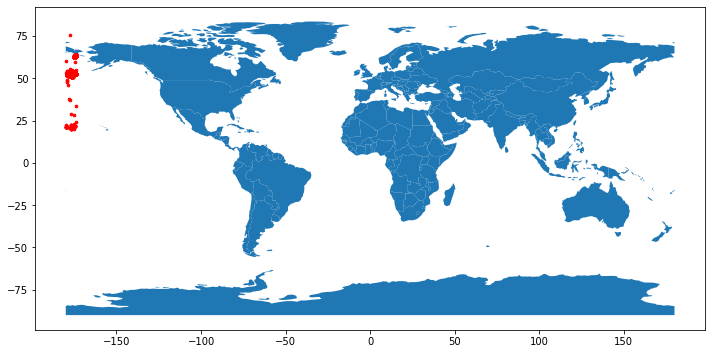

In [9]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


geometry = [Point(xy) for xy in zip(data['LON'], data['LAT'])]
gdf = GeoDataFrame(data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#plt.axis([-200,-150,0,90])
gdf.plot(ax=world.plot(figsize=(12, 16)), marker='o', color='red', markersize=7);


### (ii) Advance map using folium library

In [10]:
# install folium (if folium isn't installed, remove comment and run the cell)
# ! pip install folium

In [11]:
# make array of tuples(tuple contain latitudes & longitudes)
lats_long = []
for i in range(len(data)):
    lats_long.append((data['LAT'][i], data['LON'][i]))
    
lats_long

[(52.4873, -174.02316000000002),
 (52.48718, -174.02835),
 (52.48705, -174.03608),
 (52.41575, -174.60041),
 (52.413109999999996, -174.61718),
 (52.40527, -174.66192),
 (52.39625, -174.71461000000002),
 (52.39278, -174.73318),
 (52.38917, -174.75173999999998),
 (52.36916, -174.85096000000001),
 (52.36112, -174.89224),
 (52.35662, -174.91638999999998),
 (52.353229999999996, -174.93524),
 (52.33886, -175.01363),
 (52.337759999999996, -175.01916),
 (52.33328, -175.04233),
 (52.33142, -175.0519),
 (52.32379, -175.08993),
 (52.31912, -175.11316000000002),
 (52.3138, -175.14106999999998),
 (52.306740000000005, -175.1831),
 (52.29895, -175.22822),
 (52.29807, -175.23314),
 (52.279340000000005, -175.3618),
 (52.27749, -175.37665),
 (52.27078, -175.43518),
 (52.26965, -175.44423),
 (52.26893, -175.4491),
 (52.26706, -175.46309),
 (52.26577, -175.47284),
 (52.24853, -175.58728),
 (52.2436, -175.61771000000002),
 (52.24107, -175.63311000000002),
 (52.2352, -175.6788),
 (52.11135, -176.36222),
 (5

In [12]:
# find latitude center for all points
lat_mean = data['LAT'].mean()
lat_mean

52.864806201095455

In [13]:
# find longitude center for all points
long_mean = data['LON'].mean()
long_mean

-176.49940768681535

In [14]:
# create folium map with markers
import folium
mapit = folium.Map( location=[52.86480620109543, -176.49940768681523], zoom_start=6 )
for coord in range(500):
    folium.Marker( location=[ lats_long[coord][0], lats_long[coord][1] ], fill_color='#43d9de', radius=3 ).add_to( mapit )

# mapit.save('map.html')

In [15]:
mapit
# display map
# from IPython.display import HTML, display
# display(mapit)

# here the map isn't displaying because of long running script,
#but you can open it from any browser & can see the result. THe map is saved into the folder where Ipython Notebooks are exist

[Table of Content](#toc)

<a id='l1.2'></a>
#### 1.2. What is the average track/cargo length?

<b>Mode:</b> In stats, the mode is the one that appears the most in any range of numbers. Here to find average we find mode.

In [16]:
value_count = data['Length'].value_counts()
value_count

89.92     2846
32.95     2524
92.21     1314
63.97      823
37.22      778
172.39     740
228.99     223
299.99     177
179.90     144
333.97     130
182.00      89
180.40      62
169.37      61
174.40      60
249.97      28
334.06      21
225.30      21
189.90      17
199.95      16
199.90      16
288.93      14
366.00      14
183.20      11
260.03       7
183.00       4
184.75       2
182.87       2
291.80       1
189.96       1
50.29        1
225.00       1
199.97       1
299.94       1
175.00       1
230.00       1
228.96       1
299.95       1
224.94       1
203.82       1
11.73        1
Name: Length, dtype: int64

We can observe that 89.92 is the length that is appearing most of the time in data, so it is the average length of our data.

In [17]:
# find mode(average track length)
mode = data['Length'].mode()
mode = mode[0]
mode

89.92

In [18]:
print("The average track length is "+str(mode))

The average track length is 89.92


[Table of Content](#toc)

<a id='l1.3'></a>
#### 1.3.  Does SOG and COG vary depending on vessel type?

To find the relation b/w SOG & vessel type and COG & vessel type, we use correlation.

In [19]:
corr1 = round(data['SOG'].corr(data['VesselType']),2)
print("The correlation b/w SOG and vessel type is "+str(corr1)+" that is very small, so we can say that SOG does not vary depending upon vessel type.")

The correlation b/w SOG and vessel type is 0.02 that is very small, so we can say that SOG does not vary depending upon vessel type.


In [20]:
corr2 = round(data['COG'].corr(data['VesselType']),2)
print("The correlation b/w COG and vessel type is "+str(corr2)+" that is also very small, so we can say that COG does not vary depending upon vessel type.")

The correlation b/w COG and vessel type is 0.04 that is also very small, so we can say that COG does not vary depending upon vessel type.


[Table of Content](#toc)

<a id='l1.4'></a>
#### 1.4. How does vessel size (length and width) modify SOG or COG)?

In [21]:
# length with SOG
corr3 = round(data['Length'].corr(data['SOG']),2)
print("The correlation b/w Length and SOG is "+str(corr3)+" so we can say that vessel length modify SOG around 10%")

The correlation b/w Length and SOG is 0.1 so we can say that vessel length modify SOG around 10%


In [22]:
# length with COG
corr4 = round(data['Length'].corr(data['COG']),2)
print("The correlation b/w Length and COG is "+str(corr4)+" so we can say that vessel length modify COG around 16%.")

The correlation b/w Length and COG is 0.16 so we can say that vessel length modify COG around 16%.


In [23]:
# width with SOG
corr5 = round(data['Width'].corr(data['SOG']),2)
print("The correlation b/w Width and SOG is "+str(corr5)+" so we can say that vessel width modify SOG around 12%.")


The correlation b/w Width and SOG is 0.12 so we can say that vessel width modify SOG around 12%.


In [24]:
# width with COG

corr6 = round(data['Width'].corr(data['COG']),2)
print("The correlation b/w Width and COG is "+str(corr6)+" so we can say that vessel width modify COG around 13%.")


The correlation b/w Width and COG is 0.13 so we can say that vessel width modify COG around 13%.


[Table of Content](#toc)

<a id='l1.5'></a>
#### 1.5. What is the average speed of the ships?

In [25]:
# To find avg speed of the ships(SOG) Speed over ground, we find mode

value_count = data['SOG'].value_counts()
value_count

 0.1     1566
 0.2      443
 0.0      405
 9.5      234
 9.6      233
         ... 
 19.3       1
 19.1       1
-51.2       1
 44.3       1
 18.1       1
Name: SOG, Length: 169, dtype: int64

We can observe that 0.1 is the speed that is appearing most of the time in data, so it is the average speed of our data.

In [26]:
# find mode(average track length)
mode = data['SOG'].mode()
mode = mode[0]
mode

0.1

In [27]:
print('The avg speed of ships are '+str(mode))

The avg speed of ships are 0.1


[Table of Content](#toc)

<a id='l1.6'></a>
#### 1.6. How to modify the BaseDateTime column for analysis?

In [28]:
# 1st check the data type of the column
data['BaseDateTime'].dtype # 

dtype('O')

In [29]:
# check data
data['BaseDateTime'].head()

0    2017-01-04T11:39:36
1    2017-01-04T11:40:45
2    2017-01-04T11:42:26
3    2017-01-04T13:51:07
4    2017-01-04T13:55:17
Name: BaseDateTime, dtype: object

At this time, dtype of columns <b>BaseDateTime</b> is Object, so we change it from object to <b>datetime</b>, so this attribute becomes more comfortable for data analysis.

In [30]:
# changing dtype of BaseDateTime columns from Object to datetime
data['BaseDateTime'] =  pd.to_datetime(data['BaseDateTime'])

In [31]:
data['BaseDateTime'].dtype

dtype('<M8[ns]')

Now the column becomes more easy for data analysis, we can extract datetime parts, such as year, month, day, hour, minute & seconds very easily.

In [32]:
# extract years
pd.DatetimeIndex(data['BaseDateTime']).year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='BaseDateTime', length=10224)

In [33]:
# extract months
pd.DatetimeIndex(data['BaseDateTime']).month

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='BaseDateTime', length=10224)

In [34]:
# extract days
pd.DatetimeIndex(data['BaseDateTime']).day

Int64Index([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
            ...
            31, 31, 31, 31, 31, 31, 31, 31, 31, 31],
           dtype='int64', name='BaseDateTime', length=10224)

In [35]:
# extract hours
pd.DatetimeIndex(data['BaseDateTime']).hour

Int64Index([11, 11, 11, 13, 13, 14, 14, 14, 14, 14,
            ...
            20, 20, 21, 22, 22, 22, 23, 23, 23, 23],
           dtype='int64', name='BaseDateTime', length=10224)

In [36]:
# extract minutes
pd.DatetimeIndex(data['BaseDateTime']).minute

Int64Index([39, 40, 42, 51, 55,  6, 19, 24, 29, 54,
            ...
            21, 30, 30,  3, 18, 51,  6, 12, 30, 33],
           dtype='int64', name='BaseDateTime', length=10224)

In [37]:
# extract seconds
pd.DatetimeIndex(data['BaseDateTime']).second

Int64Index([36, 45, 26,  7, 17, 37, 57, 36, 17, 26,
            ...
            26, 27, 28, 29, 30, 31, 31, 31, 32, 32],
           dtype='int64', name='BaseDateTime', length=10224)

[Table of Content](#toc)

<a id='l2'></a>
## 2. Data Cleaning

<a id='l2.1'></a>
#### 2.1. Data contains missing values (how to use linear interpolation to solve it?)

In [38]:
# find which column contain missing values
data.isnull().any()

MMSI            False
BaseDateTime    False
LAT             False
LON             False
SOG             False
COG             False
Heading         False
VesselName       True
IMO              True
CallSign         True
VesselType       True
Status           True
Length           True
Width            True
Draft            True
Cargo            True
geometry        False
dtype: bool

In [39]:
# put all columns in a list that contain missing values

missing_values_columns = data.columns[data.isnull().any()].tolist()
missing_values_columns

['VesselName',
 'IMO',
 'CallSign',
 'VesselType',
 'Status',
 'Length',
 'Width',
 'Draft',
 'Cargo']

In [40]:
# check how much data contain missing values by one column
data['VesselName'].isnull().sum()

67

Now we make a df that gives the record about how much missing values exist in every column.

In [41]:
count_missing_values = []
for i in missing_values_columns:
    count = data[i].isnull().sum()
    count_missing_values.append(count)
    

missing_values_record = pd.DataFrame({'Column name': missing_values_columns,
                                     'Missing Value Count': count_missing_values})

missing_values_record

,Column name,Missing Value Count
0,VesselName,67
1,IMO,68
2,CallSign,68
3,VesselType,67
4,Status,3
5,Length,67
6,Width,267
7,Draft,1046
8,Cargo,3504


The above Data frame describes the no.of missing values every column contains. So now we fill missing values by <b>"linear interpolation"</b>.

In [42]:
# data = data.interpolate(method ='linear', limit_direction ='forward') 
data = pd.read_csv('AIS_2017_01_Zone01.csv')
data = data.interpolate(method='linear', axis=0).ffill().bfill()
# data.info()

Now there is no missing value exist

In [43]:
count_missing_values = []
for i in missing_values_columns:
    count = data[i].isnull().sum()
    count_missing_values.append(count)
    

missing_values_record = pd.DataFrame({'Column name': missing_values_columns,
                                     'Missing Value Count': count_missing_values})

missing_values_record

,Column name,Missing Value Count
0,VesselName,0
1,IMO,0
2,CallSign,0
3,VesselType,0
4,Status,0
5,Length,0
6,Width,0
7,Draft,0
8,Cargo,0


[Table of Content](#toc)

<a id='l3'></a>
## 3. Create a machine learning model that detects anomalies in vessel tracks

<a id='l3.1'></a>
#### 3.1. How to calculate the track of a vessel (one MMSI represents one single vessel)

In [44]:
# one MMSI represents one single vessel)
data['MMSI'].value_counts()

367390380     2846
366940480     2524
352844000     1314
273898000      823
366988820      778
373889000      740
355972000      223
353003000      176
255805913      130
477348200       89
477027500       89
311056400       62
477982600       61
356159000       60
477444700       55
273318720       49
355113000       28
477099600       21
636090965       21
370633000       17
477027300       16
355139000       16
354001000       14
477135600       12
211517000       11
636092722        7
412436952        6
538006238        4
374553000        2
477108100        2
636016266        1
79598850         1
636017139        1
367678658        1
365990248        1
366565000        1
563317000        1
955775999        1
538006875        1
303628000        1
566352000        1
367421606        1
366824942        1
316022036        1
352255000        1
565328000        1
353073000        1
229947000        1
271041862        1
355120000        1
904937494        1
733907332        1
563004900   

We'll calculate track of the top 3 vessels, that MMSI is given below.<br>
1- 367390380<br>
2- 366940480<br>
3- 352844000


In [45]:
# Make dataframe of the vessel with name track1
track1 = data[data['MMSI'] == 367390380]
track1.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
3189,367390380,2017-01-29T14:32:05,52.42239,-174.63415,8.9,-154.5,511.0,SEAFREEZE ALASKA,IMO6931043,WDE7203,1001.0,under way using engine,89.92,13.52,5.8,52.666667
3190,367390380,2017-01-29T15:30:06,52.38885,-174.85848,9.2,-148.7,511.0,SEAFREEZE ALASKA,IMO6931043,WDE7203,1001.0,under way using engine,89.92,13.52,5.8,48.333333
3191,367390380,2017-01-29T15:34:44,52.38635,-174.87590,7.9,-155.3,511.0,SEAFREEZE ALASKA,IMO6931043,WDE7203,1001.0,under way using engine,89.92,13.52,5.8,44.000000
3192,367390380,2017-01-29T15:45:34,52.38011,-174.91615,8.2,-159.9,511.0,SEAFREEZE ALASKA,IMO6931043,WDE7203,1001.0,under way using engine,89.92,13.52,5.8,39.666667
3193,367390380,2017-01-29T15:46:36,52.37952,-174.91988,9.0,-147.5,511.0,SEAFREEZE ALASKA,IMO6931043,WDE7203,1001.0,under way using engine,89.92,13.52,5.8,35.333333


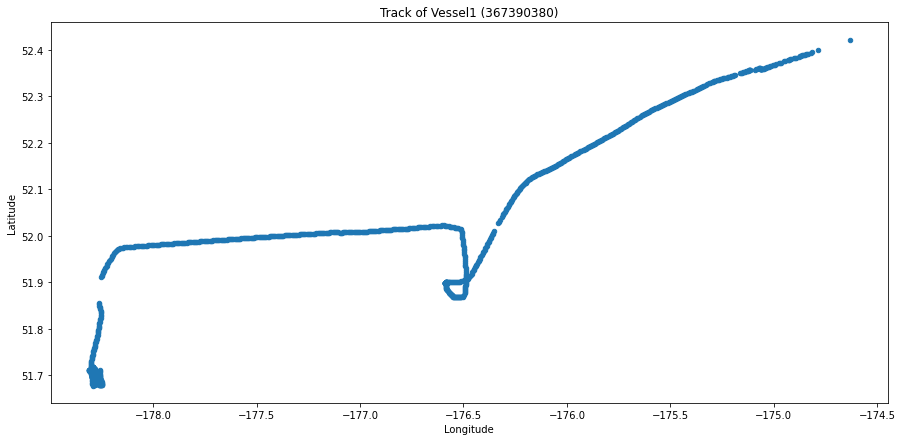

In [46]:
# Now Calculate track of the vessel1(367390380).
import matplotlib.pyplot as plt
track1.plot(kind = 'scatter', x = 'LON', y = 'LAT', figsize=(15,7))

plt.title("Track of Vessel1 (367390380)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [47]:
track2 = data[data['MMSI'] == 366940480]
track2.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,366940480,2017-01-04T11:39:36,52.48730,-174.02316,10.0,-140.7,267.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
1,366940480,2017-01-04T11:40:45,52.48718,-174.02835,10.0,-141.6,266.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
2,366940480,2017-01-04T11:42:26,52.48705,-174.03608,10.0,-142.3,267.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
3,366940480,2017-01-04T13:51:07,52.41575,-174.60041,9.1,-154.0,251.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0
4,366940480,2017-01-04T13:55:17,52.41311,-174.61718,9.1,-157.3,251.0,EARLY DAWN,IMO7821130,WDB7319,1001.0,undefined,32.95,8.82,4.0,31.0


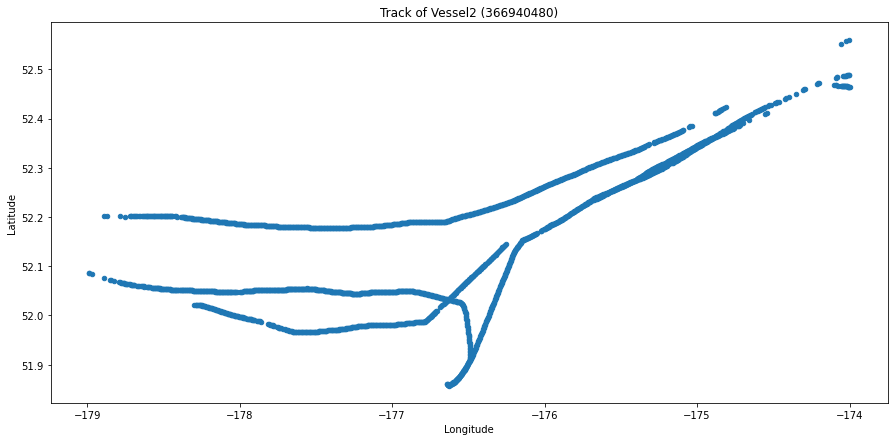

In [48]:
# Calculate track of the vessel2(366940480).
import matplotlib.pyplot as plt
track2.plot(kind = 'scatter', x = 'LON', y = 'LAT', figsize=(15,7))

plt.title("Track of Vessel2 (366940480)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [49]:
track3 = data[data['MMSI'] == 352844000]
track3.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
3426,352844000,2017-01-29T12:13:11,52.54214,-174.71065,12.9,-150.4,251.0,JACHA,IMO8512920,3EFC4,1004.0,under way using engine,92.21,16.21,6.6,70.0
3427,352844000,2017-01-29T12:37:20,52.52387,-174.84625,11.9,-145.9,253.0,JACHA,IMO8512920,3EFC4,1004.0,under way using engine,92.21,16.21,6.6,70.0
3428,352844000,2017-01-29T12:56:10,52.50233,-174.94162,12.0,-165.0,237.0,JACHA,IMO8512920,3EFC4,1004.0,under way using engine,92.21,16.21,6.6,70.0
3429,352844000,2017-01-29T14:27:00,52.40498,-175.36253,8.4,-181.5,216.0,JACHA,IMO8512920,3EFC4,1004.0,under way using engine,92.21,16.21,6.6,70.0
3430,352844000,2017-01-29T14:43:31,52.37812,-175.41420,9.5,-168.2,225.0,JACHA,IMO8512920,3EFC4,1004.0,under way using engine,92.21,16.21,6.6,70.0


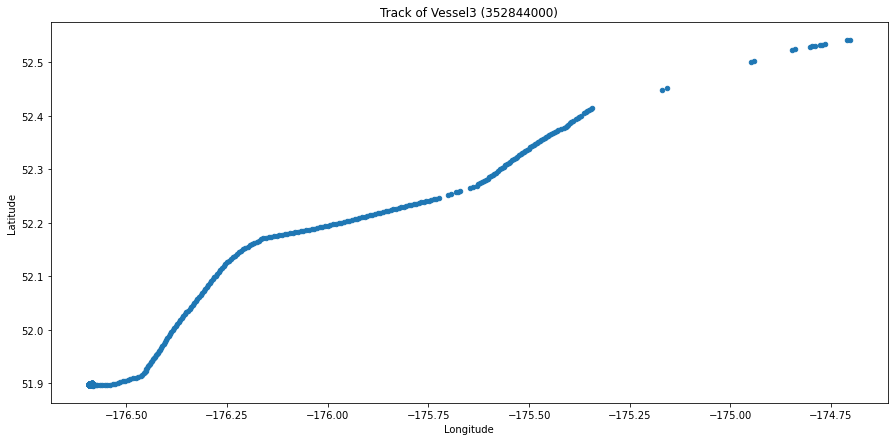

In [50]:
# Calculate track of the vessel3(352844000).
import matplotlib.pyplot as plt
track3.plot(kind = 'scatter', x = 'LON', y = 'LAT', figsize=(15,7))

plt.title("Track of Vessel3 (352844000)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [121]:
mapit_track3 = folium.Map( location=[52.86480620109543, -176.49940768681523], zoom_start=6 )
for index in range(len(track3)):
    folium.Marker( location=[ data.iloc[index]["LAT"], data.iloc[index]["LON"] ], fill_color='#43d9de', radius=3 ).add_to( mapit_track3 )

In [122]:
mapit_track3

Same as we can calculate track of all vessels

[Table of Content](#toc)

<a id='l3.2'></a>
#### 3.2. Support Vector Machines (SVM) to detect vessel anomaly behavior

In [51]:
# install keras(If keras is not intalled, then remove comment and run the cell)
# ! pip install keras

In [52]:
# install tensorflow(If tensorflow is not intalled, then remove comment and run the cell)
# ! python -m pip install --upgrade https://storage.googleapis.com/tensorflow/windows/gpu/tensorflow_gpu-2.4.0-cp36-cp36m-win_amd64.whl

We'll make the ML model for the only track1 to identify its anomaly behavior detection.


In [53]:
# importing all libraries
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [54]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [55]:
# Seperating year, month, day, hr & minute from BaseDateTime and join them in track1(dataframe) as feature.
year = pd.DatetimeIndex(track1['BaseDateTime']).year.tolist()

month = pd.DatetimeIndex(track1['BaseDateTime']).month.tolist()

day = pd.DatetimeIndex(track1['BaseDateTime']).day.tolist()

hour = pd.DatetimeIndex(track1['BaseDateTime']).hour.tolist()

minute = pd.DatetimeIndex(track1['BaseDateTime']).minute.tolist()

track1['Year'] = year
track1['month'] = month 
track1['day'] = day
track1['hour'] = hour
track1['minute'] = minute

c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [56]:
track1.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'Year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

Now BaseDatetime & geometry column is not for our use, so we drop these 2 columns. 

In [57]:
# track1.drop(['BaseDateTime', 'geometry'], axis = 1, inplace = True)
track1.drop('BaseDateTime', axis = 1, inplace = True)

c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
track1.columns

Index(['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselName', 'IMO',
       'CallSign', 'VesselType', 'Status', 'Length', 'Width', 'Draft', 'Cargo',
       'Year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [59]:
# finding best features to make model.
track1.corrwith(track1.SOG).sort_values(ascending=False)

SOG           1.000000e+00
LAT           4.903991e-01
hour          3.849963e-01
minute        1.648821e-02
Draft        -4.853380e-17
Length       -4.853380e-17
day          -6.606087e-02
LON          -8.101978e-02
Cargo        -3.084407e-01
COG          -3.793141e-01
MMSI                   NaN
Heading                NaN
VesselType             NaN
Width                  NaN
Year                   NaN
month                  NaN
dtype: float64

<AxesSubplot:title={'center':'Correlation with class'}>

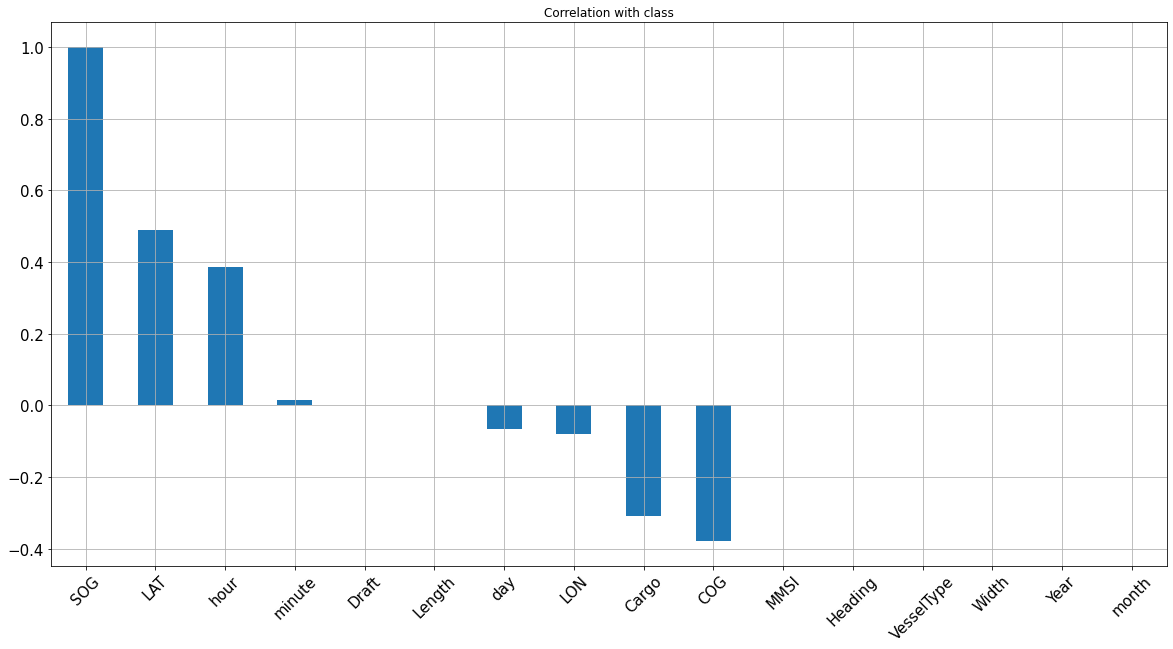

In [60]:
track1.corrwith(track1.SOG).sort_values(ascending=False).plot.bar(
        figsize = (20, 10), title = "Correlation with class", fontsize = 15,
        rot = 45, grid = True)

So for a training model that predicts SOG, we have the following features.


In [61]:
y = track1['SOG'].ravel()
y

array([8.9, 9.2, 7.9, ..., 3.1, 4.8, 4.2])

In [62]:
# X = track1[['LAT', 'hour','Cargo', 'COG']]
X = track1[['LAT', 'hour', 'LON', 'day', 'Cargo', 'COG']]

In [63]:
X.head()

,LAT,hour,LON,day,Cargo,COG
3189,52.42239,14,-174.63415,29,52.666667,-154.5
3190,52.38885,15,-174.85848,29,48.333333,-148.7
3191,52.38635,15,-174.87590,29,44.000000,-155.3
3192,52.38011,15,-174.91615,29,39.666667,-159.9
3193,52.37952,15,-174.91988,29,35.333333,-147.5


Normalize all the features with in range(0,1)

In [64]:
from sklearn.preprocessing import StandardScaler
X['normalizedLAT'] = StandardScaler().fit_transform(X['LAT'].values.reshape(-1,1))
X['normalizedhour'] = StandardScaler().fit_transform(X['hour'].values.reshape(-1,1))
X['normalizedday'] = StandardScaler().fit_transform(X['day'].values.reshape(-1,1))
X['normalizedLon'] = StandardScaler().fit_transform(X['LON'].values.reshape(-1,1))
X['normalizedCargo'] = StandardScaler().fit_transform(X['Cargo'].values.reshape(-1,1))
X['normalizedCOG'] = StandardScaler().fit_transform(X['COG'].values.reshape(-1,1))


#track1 = credit_card_data_sample.drop(['Amount'],axis=1)
X.drop(['LAT', 'hour', 'day', 'LON', 'Cargo', 'COG'], axis = 1, inplace = True)



c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [65]:
X.head()

,normalizedLAT,normalizedhour,normalizedday,normalizedLon,normalizedCargo,normalizedCOG
3189,3.578245,0.211003,-1.846064,2.909092,-0.660828,-0.915086
3190,3.336228,0.352801,-1.846064,2.601586,-0.969856,-0.871154
3191,3.318188,0.352801,-1.846064,2.577707,-1.278885,-0.921146
3192,3.273162,0.352801,-1.846064,2.522534,-1.587914,-0.955989
3193,3.268905,0.352801,-1.846064,2.517421,-1.896943,-0.862065


In [66]:
y[:5]

array([8.9, 9.2, 7.9, 8.2, 9. ])

In [67]:
# train & test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (2419, 6) (2419,)
Test set: (427, 6) (427,)


In [68]:
# import SVR from SVM
from sklearn.svm import SVR

In [69]:
# building model 
regressor = SVR(gamma='scale', C = 100000, epsilon=1, degree=3)

In [70]:
# fitting model
regressor.fit(x_train, y_train)

SVR(C=100000, epsilon=1)

In [71]:
yhat = regressor.predict(x_test)
yhat [0:5]

array([ 0.74668405, -0.69270736,  0.20289189,  8.77794271,  0.49214883])

In [72]:
# find accuracy(R2 Score)
from sklearn.metrics import r2_score
print(round(r2_score(y_test, yhat),2))

0.97


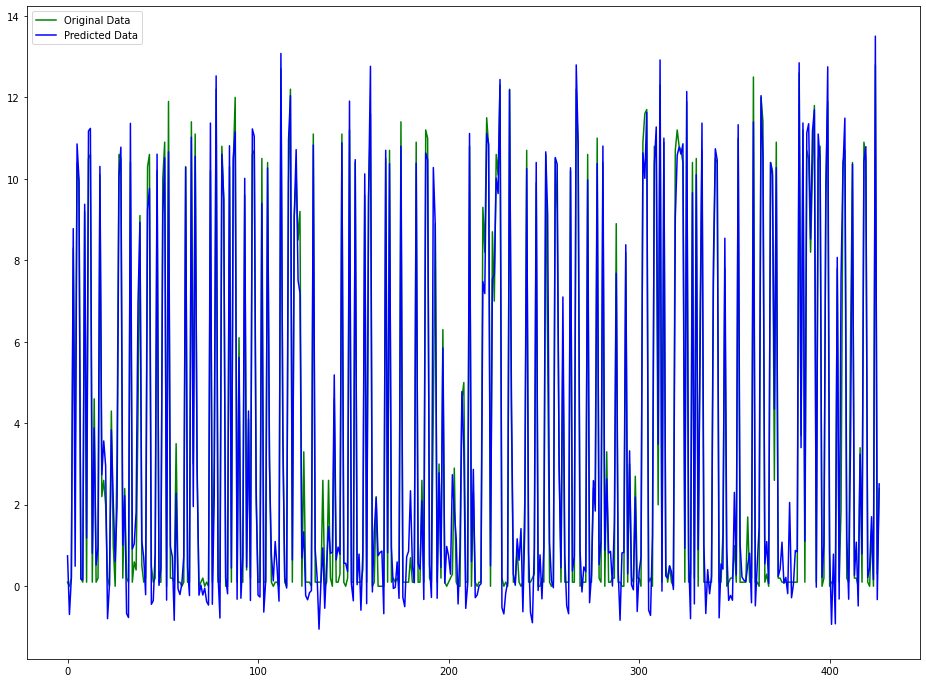

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
labels = ['Original Data', 'Predicted Data']
plt.plot(y_test, color = 'green', label = 'Original Data')
plt.plot(yhat, color = 'blue', label = 'Predicted Data')
plt.legend(labels)
plt.show()

In [74]:
# round off predicted values
import numpy as np
yhat = np.round(yhat,1)
yhat[:5]

array([ 0.7, -0.7,  0.2,  8.8,  0.5])

In [75]:
# make df of predicted & real values
predicted_vs_real = pd.DataFrame({'Actual': y_test,
                                 'Predicted': yhat})

predicted_vs_real

,Actual,Predicted
0,0.1,0.7
1,0.0,-0.7
2,0.2,0.2
3,8.3,8.8
4,3.0,0.5
...,...,...
422,1.4,1.7
423,0.0,0.2
424,12.8,13.5
425,0.3,-0.3


In [76]:
predicted_vs_real['difference'] = predicted_vs_real['Actual'] - predicted_vs_real['Predicted']
predicted_vs_real

,Actual,Predicted,difference
0,0.1,0.7,-0.6
1,0.0,-0.7,0.7
2,0.2,0.2,0.0
3,8.3,8.8,-0.5
4,3.0,0.5,2.5
...,...,...,...
422,1.4,1.7,-0.3
423,0.0,0.2,-0.2
424,12.8,13.5,-0.7
425,0.3,-0.3,0.6


In [77]:
rounded_difference = predicted_vs_real['difference'].tolist()
rounded_difference = np.round(rounded_difference,0)

In [78]:
predicted_vs_real['Rounded Difference'] = rounded_difference
predicted_vs_real

,Actual,Predicted,difference,Rounded Difference
0,0.1,0.7,-0.6,-1.0
1,0.0,-0.7,0.7,1.0
2,0.2,0.2,0.0,0.0
3,8.3,8.8,-0.5,-0.0
4,3.0,0.5,2.5,2.0
...,...,...,...,...
422,1.4,1.7,-0.3,-0.0
423,0.0,0.2,-0.2,-0.0
424,12.8,13.5,-0.7,-1.0
425,0.3,-0.3,0.6,1.0


In [79]:
predicted_vs_real['Rounded Difference'].value_counts()

 0.0    240
-1.0    102
 1.0     66
 2.0      9
-2.0      6
-6.0      2
-3.0      2
Name: Rounded Difference, dtype: int64

In [102]:
# The rows giving larger difference are anamolous
anomalies = predicted_vs_real[(predicted_vs_real['Rounded Difference']>= 6) |(predicted_vs_real['Rounded Difference']<= -6)] 
anomalies

,Actual,Predicted,difference,Rounded Difference
192,4.3,10.3,-6.0,-6.0
406,1.9,7.6,-5.7,-6.0


In [103]:
len(x_test)

427

In [104]:
x_test.reset_index(inplace = True)

In [105]:
x_test.drop('index', axis = 1, inplace = True)

c:\users\prabh\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [106]:
x_test

,normalizedLAT,normalizedhour,normalizedday,normalizedLon,normalizedCargo,normalizedCOG
0,-0.210766,-1.774169,1.029633,0.237464,0.575287,0.647539
1,-0.208024,1.487185,-0.408216,0.237601,0.575287,1.348183
2,-0.202540,-1.632371,-0.408216,0.234695,0.575287,0.689199
3,3.286583,0.352801,-1.846064,2.540134,-1.564142,-0.937810
4,-1.666047,1.487185,1.029633,-2.063712,-2.205971,1.479223
...,...,...,...,...,...,...
422,-1.545832,1.345387,1.029633,-2.099860,-0.003495,-0.822677
423,-0.208385,-1.490573,1.029633,0.237245,-1.477776,-0.202323
424,0.350406,0.494599,1.029633,-1.885429,0.931859,-0.826464
425,-0.207952,1.345387,-0.408216,0.237670,0.575287,1.676918


In [107]:
anomalies_indices = anomalies.index.tolist()
anomalies_indices

[192, 406]

In [108]:
# So now the anomalies are:
x_test.iloc[anomalies_indices]

,normalizedLAT,normalizedhour,normalizedday,normalizedLon,normalizedCargo,normalizedCOG
192,-0.147989,1.487185,-1.846064,0.370306,0.575287,-0.937052
406,3.117156,0.494599,-1.846064,2.323977,0.575287,-0.716634


The rows of the above data frame containing anomalous values.

<a id='conclusion'></a>
## Conclusion:
So in this way, we can predict any feature of AIS data and then find anomaly behavior of any vessel.

In [116]:
# Latitude and Longitude where there are high chances of oil spills
for index in anomalies_indices:
    print("Latitude -" ,data.iloc[index]["LAT"], " Longitude - ", data.iloc[index]["LON"])

Latitude - 52.07227  Longitude -  -176.49806999999998
Latitude - 63.19035  Longitude -  -174.10293000000001


In [127]:
mapit_anomalies = folium.Map( location=[52.86480620109543, -176.49940768681523], zoom_start=4 )
for index in anomalies_indices:
    folium.Marker( location=[ data.iloc[index]["LAT"], data.iloc[index]["LON"] ], fill_color='#43d9de', radius=3 ).add_to( mapit_anomalies )

In [128]:
mapit_anomalies